<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/augmentation/cutmix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CutMix: Augmentacja danych
##Import bibliotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

##Załadowanie zbioru CIFAR-10

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck"
]

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


##Hiperparametry

In [3]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 32

In [10]:
def preprocess_image(img, label):
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  img = tf.image.convert_image_dtype(img, tf.float32) / 255.0
  return img, label

##Konwersja danych na obiekty TensorFlow Dataset

In [12]:
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_simple = tf.data.Dataset.from_tensor_slices((x_train, y_train))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds_simple = (
    train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Połączenie dwóch przetasowanych zbiorów z tych samych danych
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

##Definicja funkcji augmentacji danych CutMix

In [35]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
  gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
  gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
  return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

@tf.function
def get_box(lambda_value):
  cut_rat = tf.math.sqrt(1.0 - lambda_value)

  cut_w = IMG_SIZE * cut_rat 
  cut_w = tf.cast(cut_w, tf.int32)

  cut_h = IMG_SIZE * cut_rat
  cut_h = tf.cast(cut_h, tf.int32)

  cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)
  cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)

  boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
  boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
  bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
  bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

  target_h = bby2 - boundaryy1
  if target_h == 0:
    target_h += 1

  target_w = bbx2 - boundaryx1
  if target_w == 0:
    target_w += 1

  return boundaryx1, boundaryy1, target_h, target_w

@tf.function
def cutmix(train_ds_one, train_ds_two):
  (image1, label1), (image2, label2) = train_ds_one, train_ds_two

  alpha = [0.25]
  beta = [0.25]

  # Pobranie próbki z rozkładu Beta
  lambda_value = sample_beta_distribution(1, alpha, beta)

  # Deklaracja Lambdy
  lambda_value = lambda_value[0][0]  

  # Pobranie offsetów, wysokości i szerokości ramek
  boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

  crop2 = tf.image.crop_to_bounding_box(
      image2, boundaryy1, boundaryx1, target_h, target_w
  )
  image2 = tf.image.pad_to_bounding_box(
      crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
  )
  crop1 = tf.image.crop_to_bounding_box(
      image1, boundaryy1, boundaryx1, target_h, target_w
  )
  img1 = tf.image.pad_to_bounding_box(
      crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
  )

  image1 = image1 - img1 
  image = image1 + image2

  lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
  lambda_value = tf.cast(lambda_value, tf.float32)

  # Połączenie etykiet obu obrazów
  label = lambda_value * label1 + (1 - lambda_value) * label2
  return image, label

##Wizualizacja nowego zbioru po augmentacji CutMix

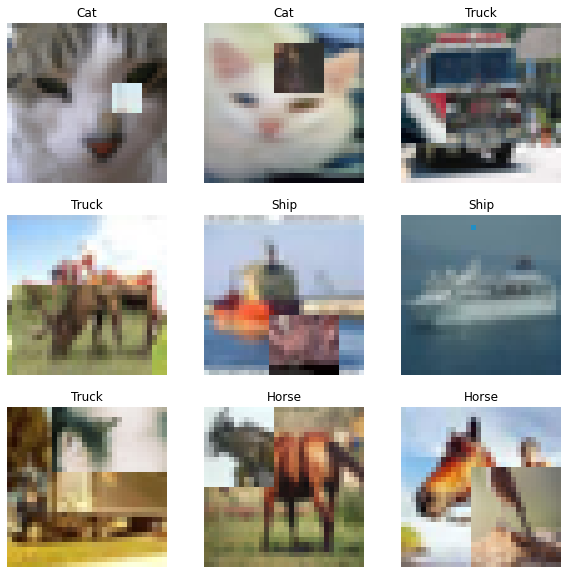

In [36]:
# Stworzenie nowego zbioru z użyciem cutmix
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

img_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.title(class_names[np.argmax(label_batch[i])])
  plt.imshow(img_batch[i])
  plt.axis('off')